In [1]:
import numpy as np
!pip install deepxde
import deepxde as dde

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
a = 0.4
L = 1
n = 1

In [ ]:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx

In [ ]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)

In [ ]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.076011 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.569528 s



In [ ]:
losshistory, train_state = model.train(iterations=20000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.24e-01, 4.04e-02, 6.73e-01]    [2.27e-01, 4.04e-02, 6.73e-01]    []  
1000      [2.85e-03, 1.15e-03, 7.83e-04]    [1.84e-03, 1.15e-03, 7.83e-04]    []  
2000      [4.83e-04, 9.95e-05, 9.90e-05]    [3.67e-04, 9.95e-05, 9.90e-05]    []  


KeyboardInterrupt: 

Compiling model...
Building feed-forward neural network...
'build' took 0.089569 s

'compile' took 0.711823 s

Training model...

0         [1.58e-02, 7.66e-02, 2.95e-01]    [1.52e-02, 7.66e-02, 2.95e-01]    []  
1000      [2.52e-04, 1.18e-04, 7.11e-05]    [1.22e-04, 1.18e-04, 7.11e-05]    []  
2000      [5.58e-05, 2.88e-05, 1.49e-05]    [3.09e-05, 2.88e-05, 1.49e-05]    []  
3000      [3.00e-05, 1.12e-05, 4.61e-06]    [1.71e-05, 1.12e-05, 4.61e-06]    []  
4000      [3.48e-05, 5.24e-06, 5.20e-06]    [2.14e-05, 5.24e-06, 5.20e-06]    []  
5000      [2.10e-05, 3.31e-06, 2.04e-06]    [1.18e-05, 3.31e-06, 2.04e-06]    []  
6000      [1.58e-05, 2.31e-06, 1.06e-06]    [8.62e-06, 2.31e-06, 1.06e-06]    []  
7000      [1.55e-05, 3.25e-06, 7.14e-06]    [8.76e-06, 3.25e-06, 7.14e-06]    []  
8000      [2.65e-05, 5.92e-06, 1.87e-05]    [2.20e-05, 5.92e-06, 1.87e-05]    []  
9000      [1.07e-05, 1.87e-06, 3.27e-06]    [5.97e-06, 1.87e-06, 3.27e-06]    []  
10000     [8.52e-06, 1.73e-06, 1.48e-06]

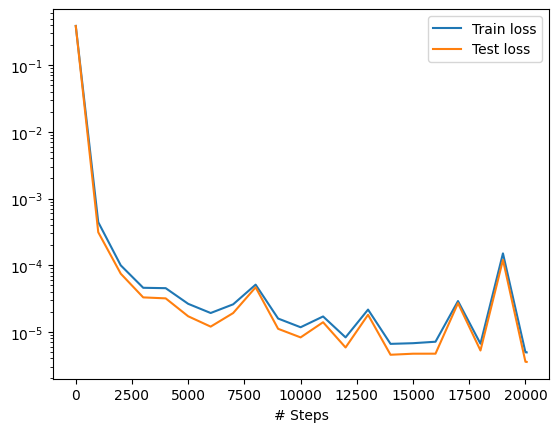

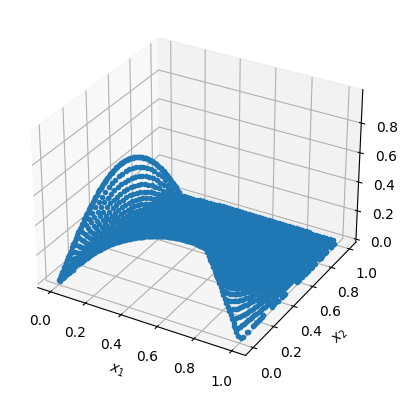

Mean residual: 0.0013453782
L2 relative error: 0.001832461330202286


In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np


def heat_eq_exact_solution(x, t):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)


def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you dont have one):
gen_exact_solution()


def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))